In [1]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
import pickle
import wntr
import wntr.metrics.economic as economics
from testWN import testWN as twm
import numpy as np
import pandas as pd
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
%matplotlib notebook

# Water Network

In [3]:
#inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
inp_file = '../Code/c-town_true_network_simplified_controls.inp'

ctown = twm(inp_file)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



Get network information:

In [4]:
## nodes = ctown.getNodeName()
links = ctown.getLinkName()
nodes = ctown.getNodeName()
pump_df = pd.DataFrame(np.ones(len(links[0])).reshape(1,-1), columns=links[0])
valves_df = pd.DataFrame(2*np.ones(len(links[2])).reshape(1,-1), columns=links[2])
pv_df = pd.concat((pump_df, valves_df), axis=1)

nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

<IPython.core.display.Javascript object>


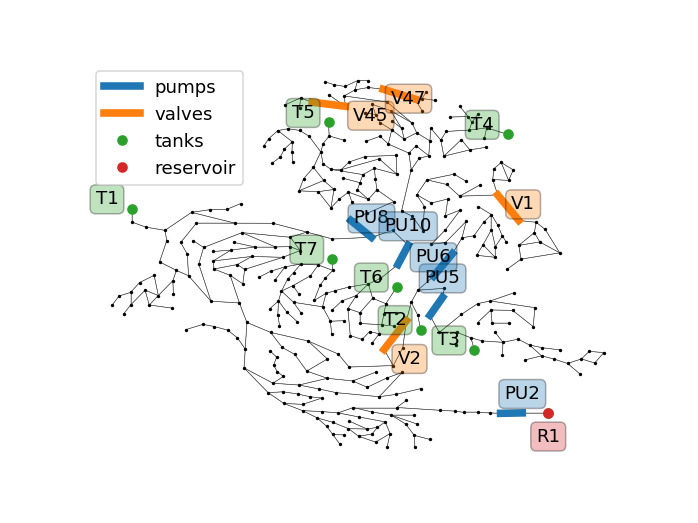

In [21]:
fig, ax = plt.subplots()
wntr.graphics.plot_network(ctown.wn,node_size=5, link_width=0.2, ax=ax)

for link_i in links[0]:
    start_i = nw_link_df[link_i].loc['start_node'].__dict__['_coordinates']
    end_i = nw_link_df[link_i].loc['end_node'].__dict__['_coordinates']
    data = np.array([start_i, end_i]).T
    pump_line = ax.plot(data[0], data[1], linewidth=5, color=colors[0])
    
    ax.text(start_i[0],start_i[1]+200, link_i, ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=colors[0], alpha=0.3))
    
for link_i in links[2]:
    start_i = nw_link_df[link_i].loc['start_node'].__dict__['_coordinates']
    end_i = nw_link_df[link_i].loc['end_node'].__dict__['_coordinates']
    data = np.array([start_i, end_i]).T
    valve_line = ax.plot(data[0], data[1], linewidth=5, color=colors[1])
    
    ax.text(start_i[0]+200, start_i[1]-100, link_i, ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=colors[1], alpha=0.3))
    
for node_i in nodes[0]:
    coords_i = nw_node_df[node_i].loc['coordinates']
    tank_dot = ax.plot(coords_i[0], coords_i[1], 'o', color=colors[2])
    ax.text(coords_i[0]-200, coords_i[1]+100, node_i, ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=colors[2], alpha=0.3))
    
for node_i in nodes[1]:
    coords_i = nw_node_df[node_i].loc['coordinates']
    res_dot = ax.plot(coords_i[0], coords_i[1], 'o', color=colors[2])
    
    res_dot = ax.plot(coords_i[0], coords_i[1], 'o', color=colors[3])
    
    ax.text(coords_i[0],coords_i[1]-250, node_i, ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=colors[3], alpha=0.3))
    
ax.legend(pump_line+valve_line+tank_dot+res_dot,['pumps','valves', 'tanks', 'reservoir'])

# Results

In [9]:
#with open('results.pkl', 'rb') as f:
with open('/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/results_sim_59.pkl', 'rb') as f:
    results=pickle.load(f)

In [10]:
results.node.keys()

dict_keys(['demand', 'head', 'pressure', 'quality'])

In [15]:
fig, ax = plt.subplots(2,1)
results.node['demand'][nodes[0]].plot()

# Plotting

## Nodes

In [9]:
toPlotNames = ctown.getNodeName()

<IPython.core.display.Javascript object>


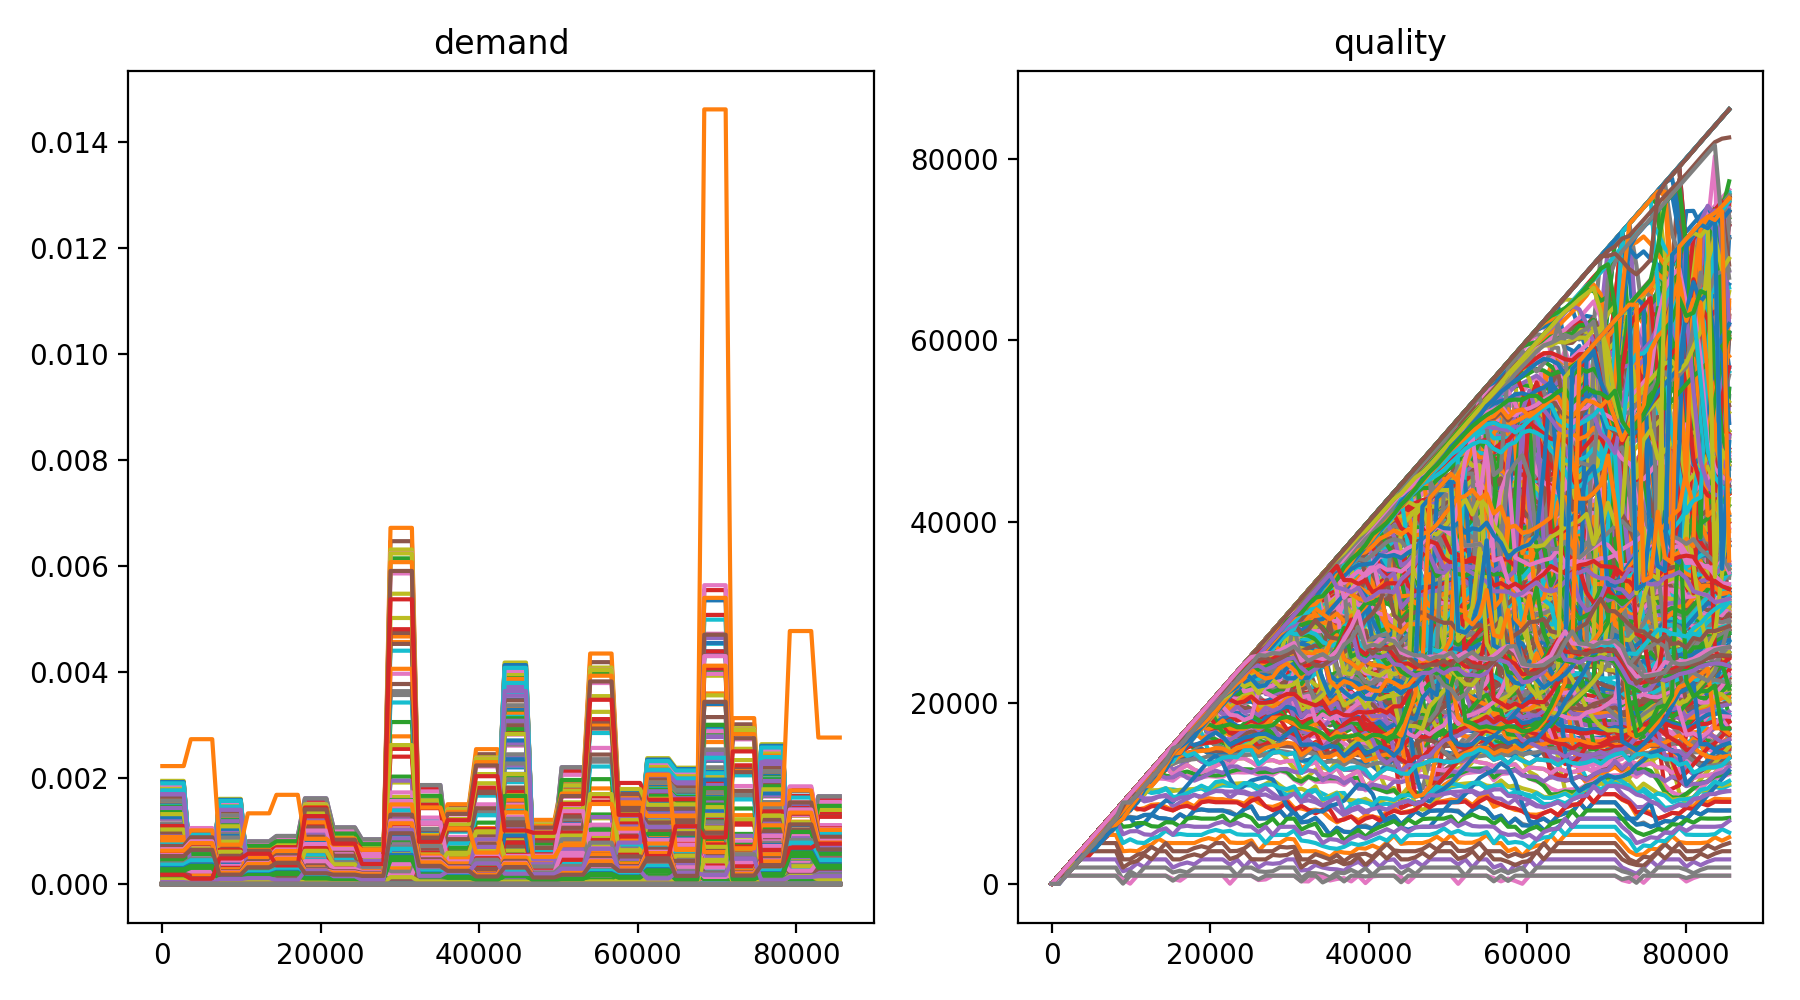

In [10]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(9,5))
demand = results.node['demand'][toPlotNames[2]] # Junctions
quality = results.node['quality'][toPlotNames[2]] # Junctions
ax_1[0].plot(demand)
ax_1[0].set_title('demand')
ax_1[1].plot(quality)
ax_1[1].set_title('quality')
fig_1.tight_layout()



<IPython.core.display.Javascript object>


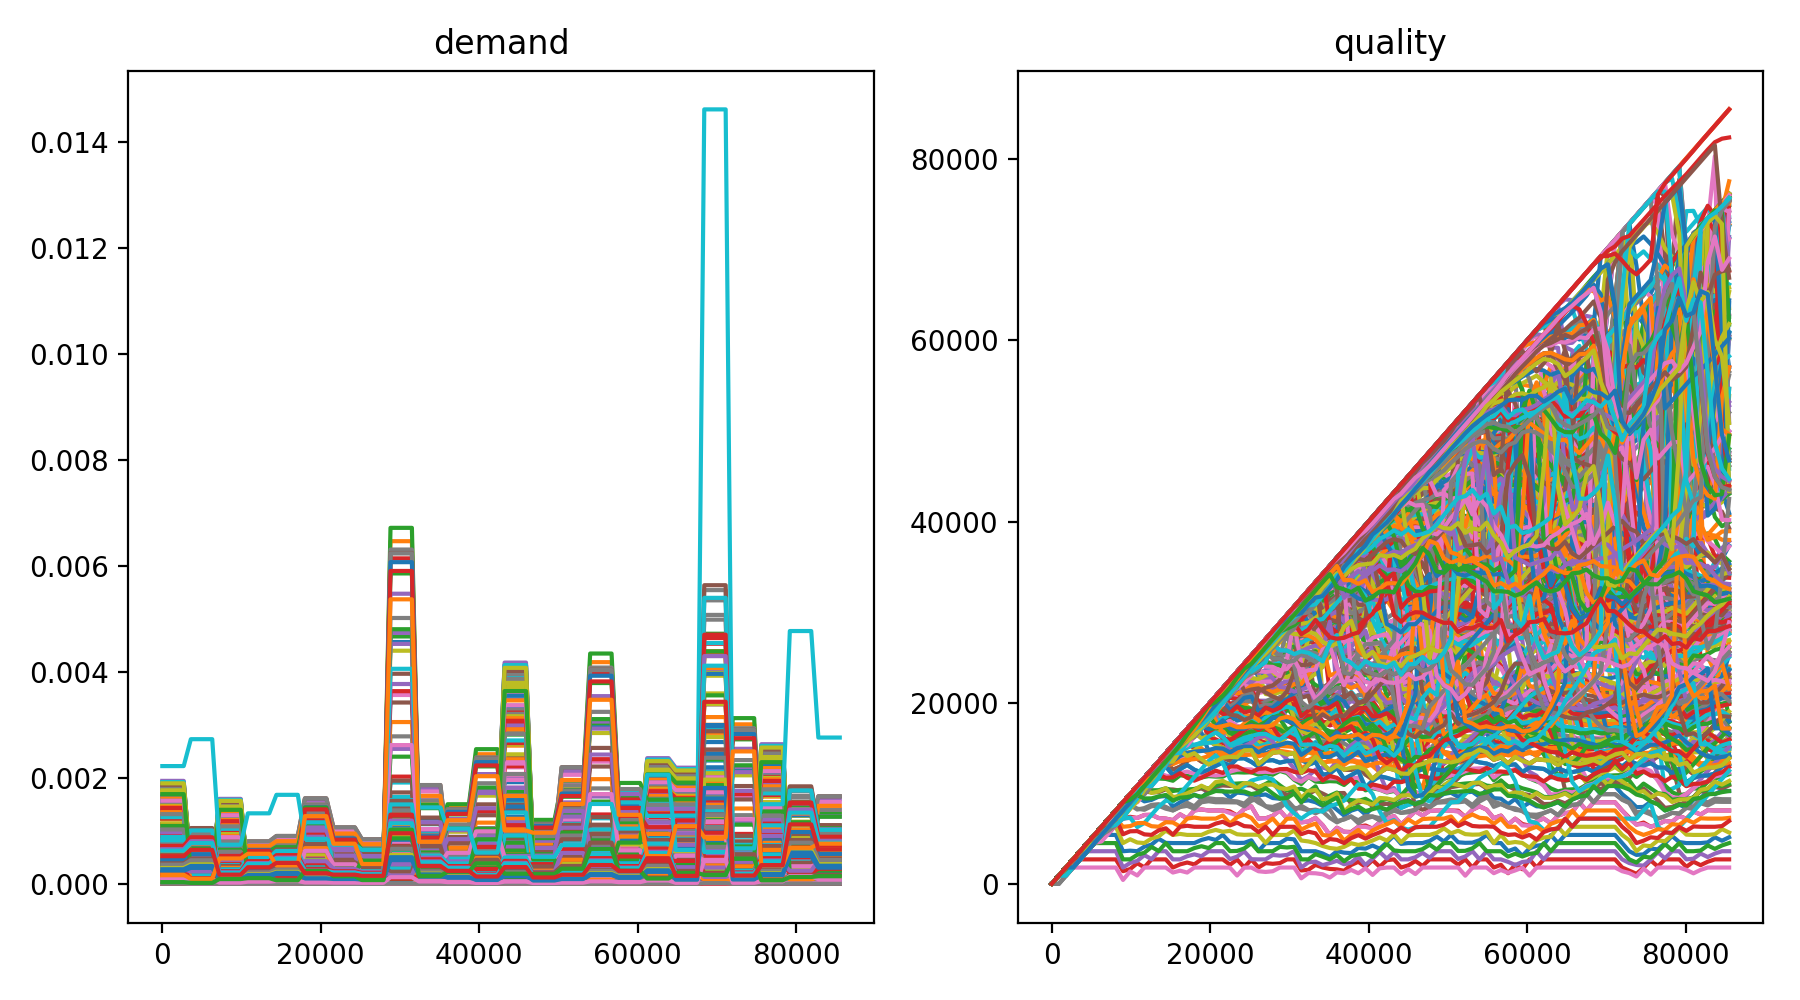

In [11]:
# Same plot, but for only nodes with positive demands
fig_1, ax_1 = plt.subplots(1,2, figsize=(9,5))
demand = results.node['demand'][toPlotNames[2]] # Junctions
quality = results.node['quality'][toPlotNames[2]] # Junctions
position = demand.sum(axis=0) > 0
posdemand = demand.loc[:, position==True]
posquality = quality.loc[:, position==True]
ax_1[0].plot(posdemand)
ax_1[0].set_title('demand')
ax_1[1].plot(posquality)
ax_1[1].set_title('quality')
fig_1.tight_layout()

<IPython.core.display.Javascript object>


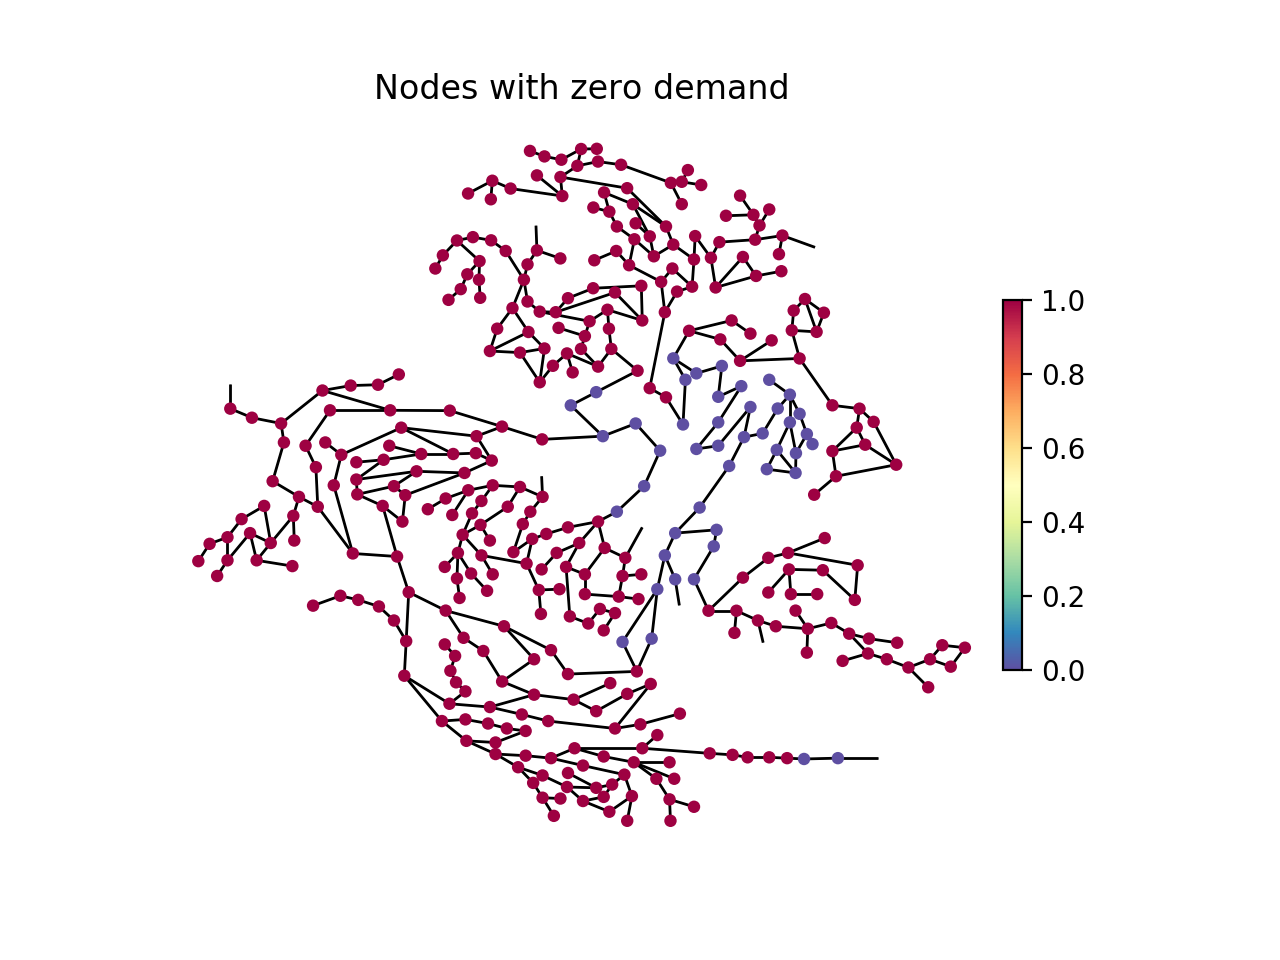

(<matplotlib.collections.PathCollection at 0x101f2901d0>,
 <matplotlib.collections.LineCollection at 0x101c320ac8>)

In [12]:
wntr.graphics.plot_network(ctown.wn, node_attribute=position, title='Nodes with zero demand')

<IPython.core.display.Javascript object>


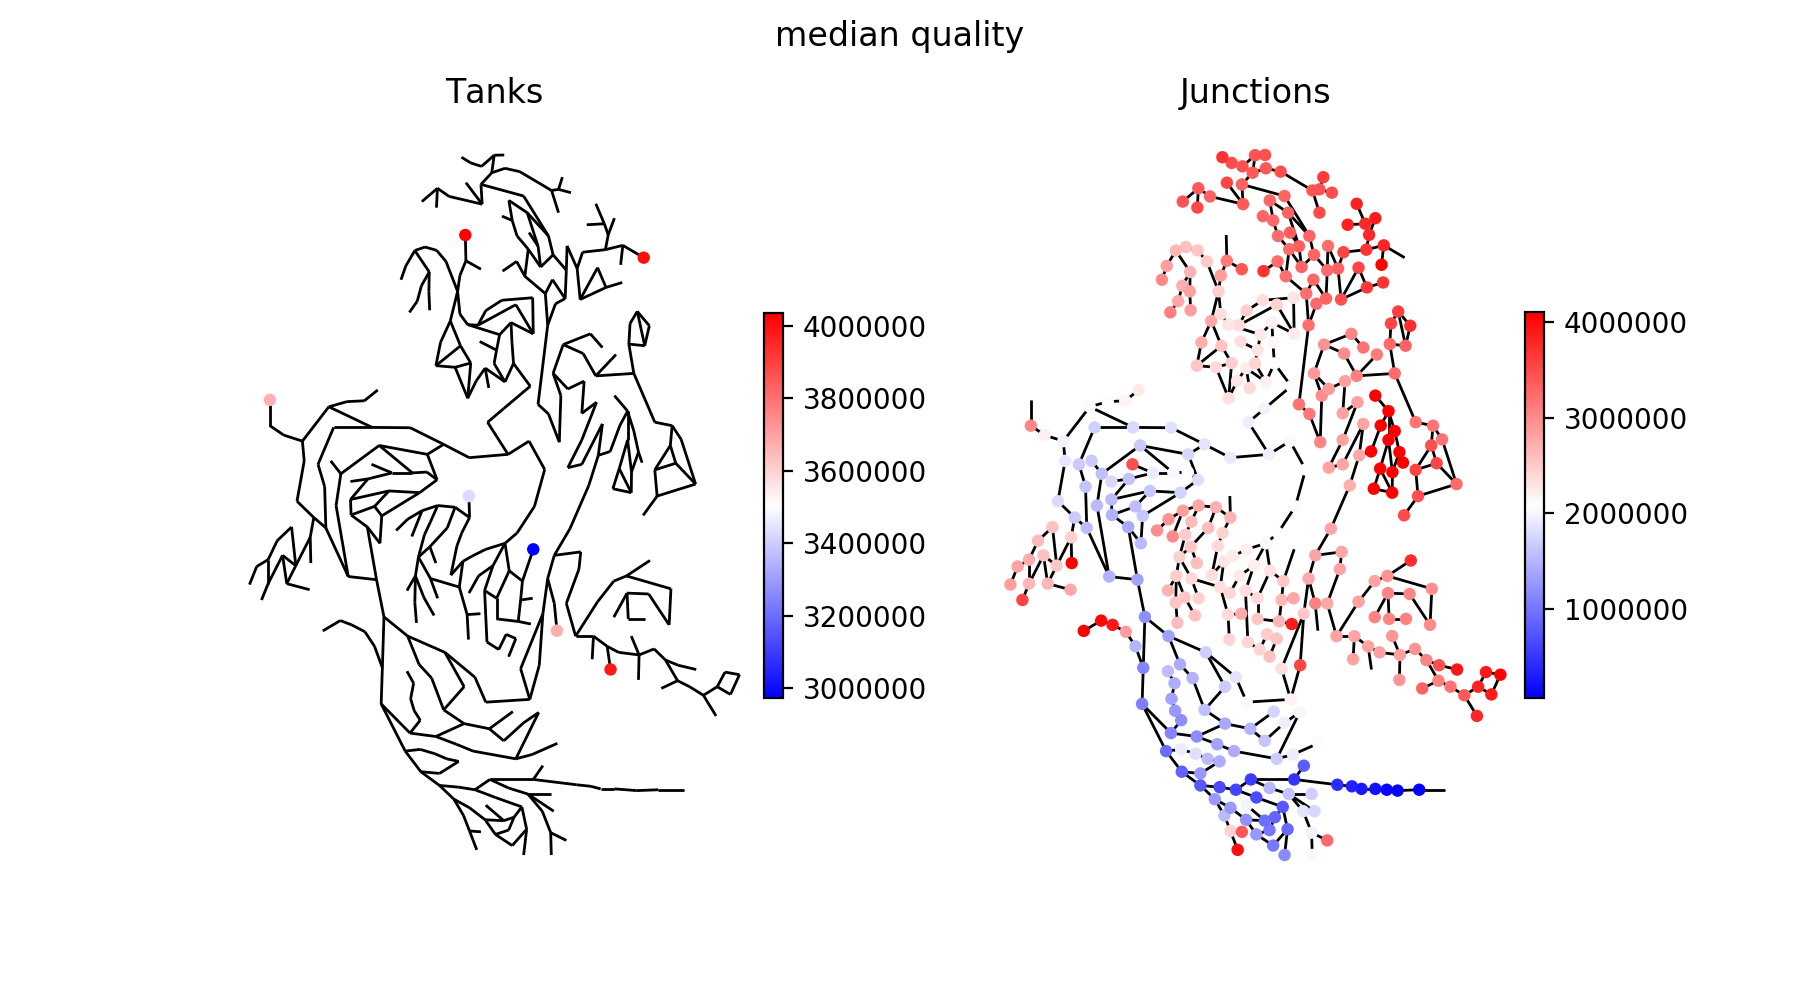

(<matplotlib.collections.PathCollection at 0x101cca2eb8>,
 <matplotlib.collections.LineCollection at 0x101cb84358>)

In [13]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(9,5))
fig_2.suptitle('median quality', fontsize=12)
df = results.node['quality']
df_med = df.sum()

wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[0]], node_cmap='bwr', title='Tanks', ax=ax_2[0])  # tanks
wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[2]], node_cmap='bwr', title='Junctions', ax=ax_2[1])  # junctions

<IPython.core.display.Javascript object>


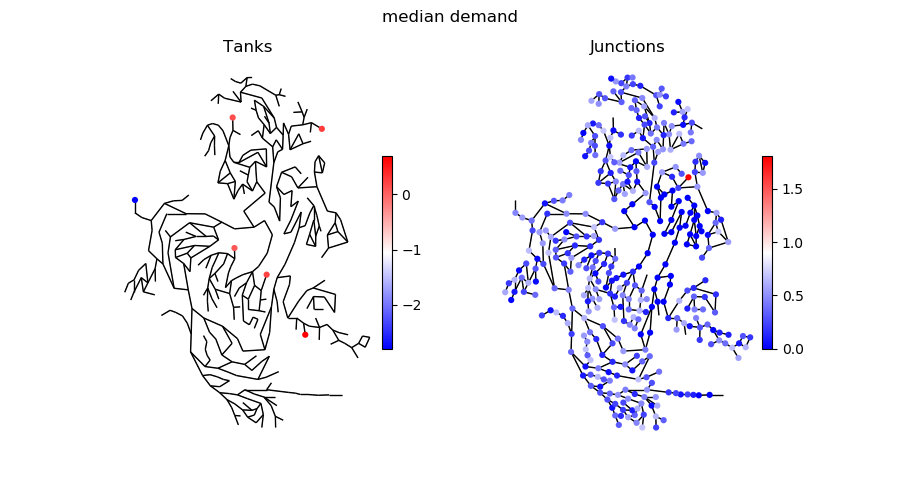

(<matplotlib.collections.PathCollection at 0x102d89afd0>,
 <matplotlib.collections.LineCollection at 0x102d88f390>)

In [45]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(9,5))
fig_2.suptitle('median demand', fontsize=12)
df = results.node['demand']
df_med = df.sum()

wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[0]], node_cmap='bwr', title='Tanks', ax=ax_2[0])  # tanks
wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[2]], node_cmap='bwr', title='Junctions', ax=ax_2[1])  # junctions

<IPython.core.display.Javascript object>


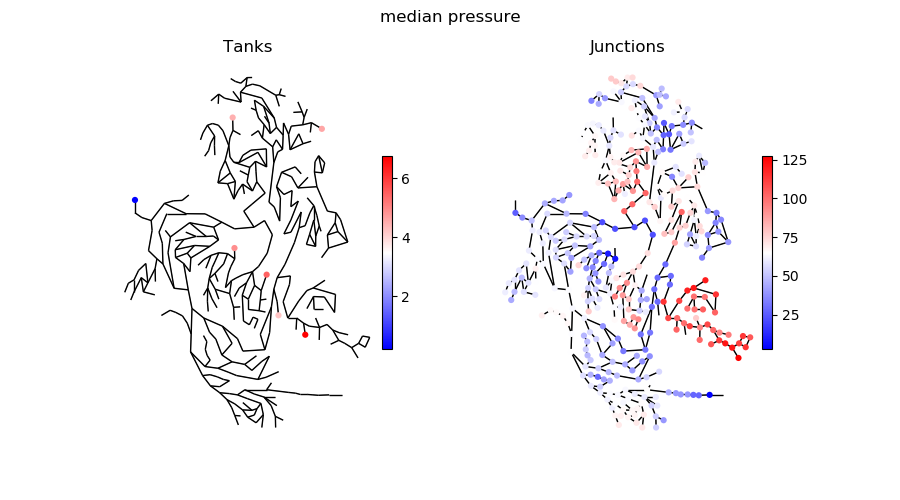

(<matplotlib.collections.PathCollection at 0x1026beb4e0>,
 <matplotlib.collections.LineCollection at 0x1026beb780>)

In [15]:
fig_3, ax_3 = plt.subplots(1,2, figsize=(9,5))
fig_3.suptitle('median pressure', fontsize=12)
df = results.node['pressure']
df_med = df.median()

wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[0]], node_cmap='bwr', title='Tanks', ax=ax_3[0])  # tanks
wntr.graphics.plot_network(ctown.wn, node_attribute=df_med[toPlotNames[2]], node_cmap='bwr', title='Junctions', ax=ax_3[1])  # junctions

## Links

In [14]:
results.link.keys()

dict_keys(['linkquality', 'flowrate', 'headloss', 'velocity', 'status', 'setting', 'frictionfact', 'rxnrate'])

### Pump 6

<IPython.core.display.Javascript object>


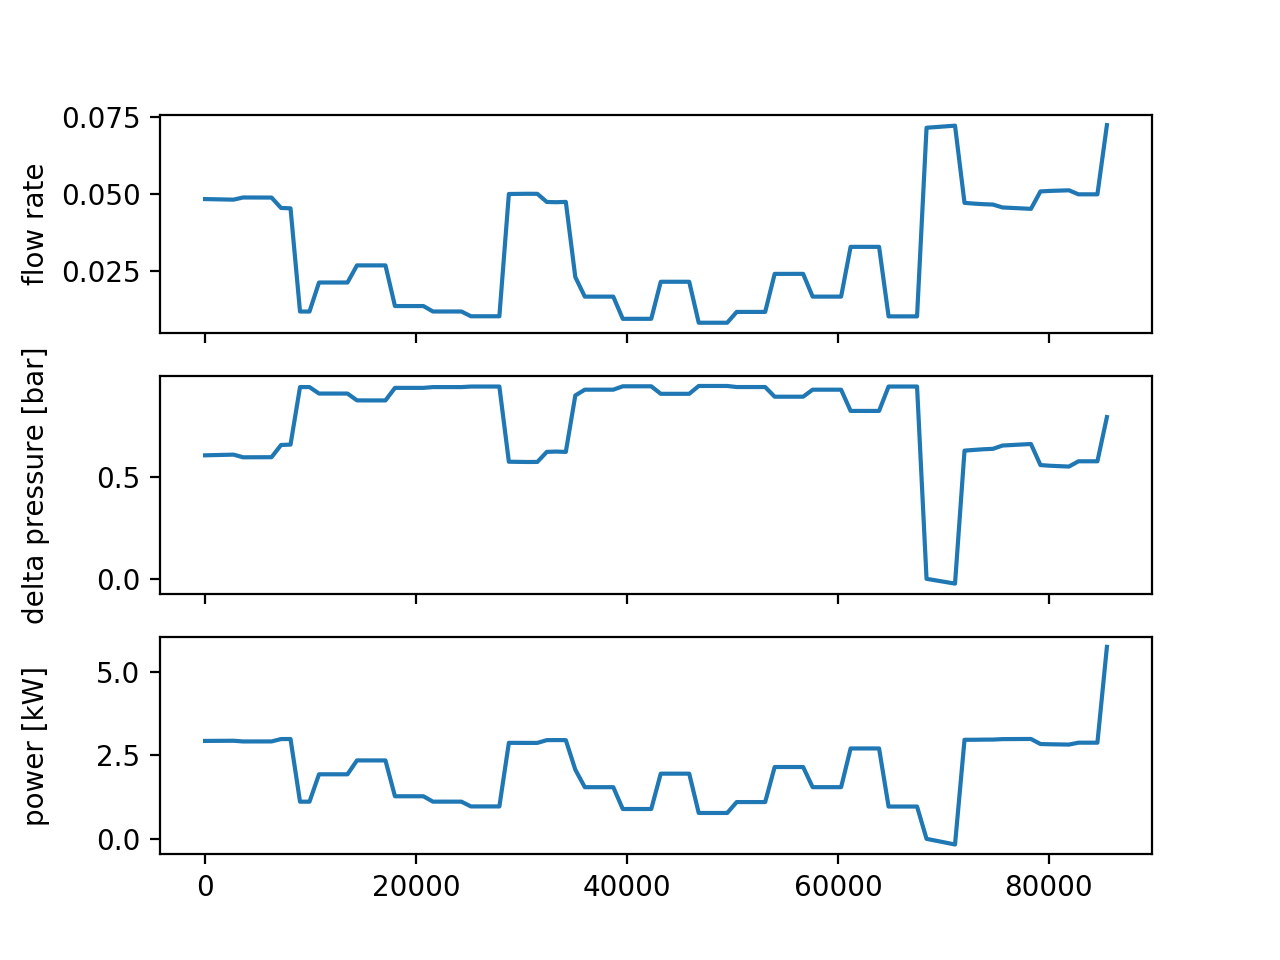

In [15]:
fig_4, ax_4 = plt.subplots(3,1, sharex=True)
v_6 = results.link['flowrate']['PU6']
dp_6 = (results.node['pressure']['J415']-results.node['pressure']['J289'])*1000
p_6 = v_6*dp_6
ax_4[0].plot(v_6)
ax_4[0].set_ylabel('flow rate')
ax_4[1].plot(dp_6/1e5)
ax_4[1].set_ylabel('delta pressure [bar]')
ax_4[2].plot(p_6/1000)
ax_4[2].set_ylabel('power [kW]')

fig_4.align_labels()

### Valve 45

<IPython.core.display.Javascript object>


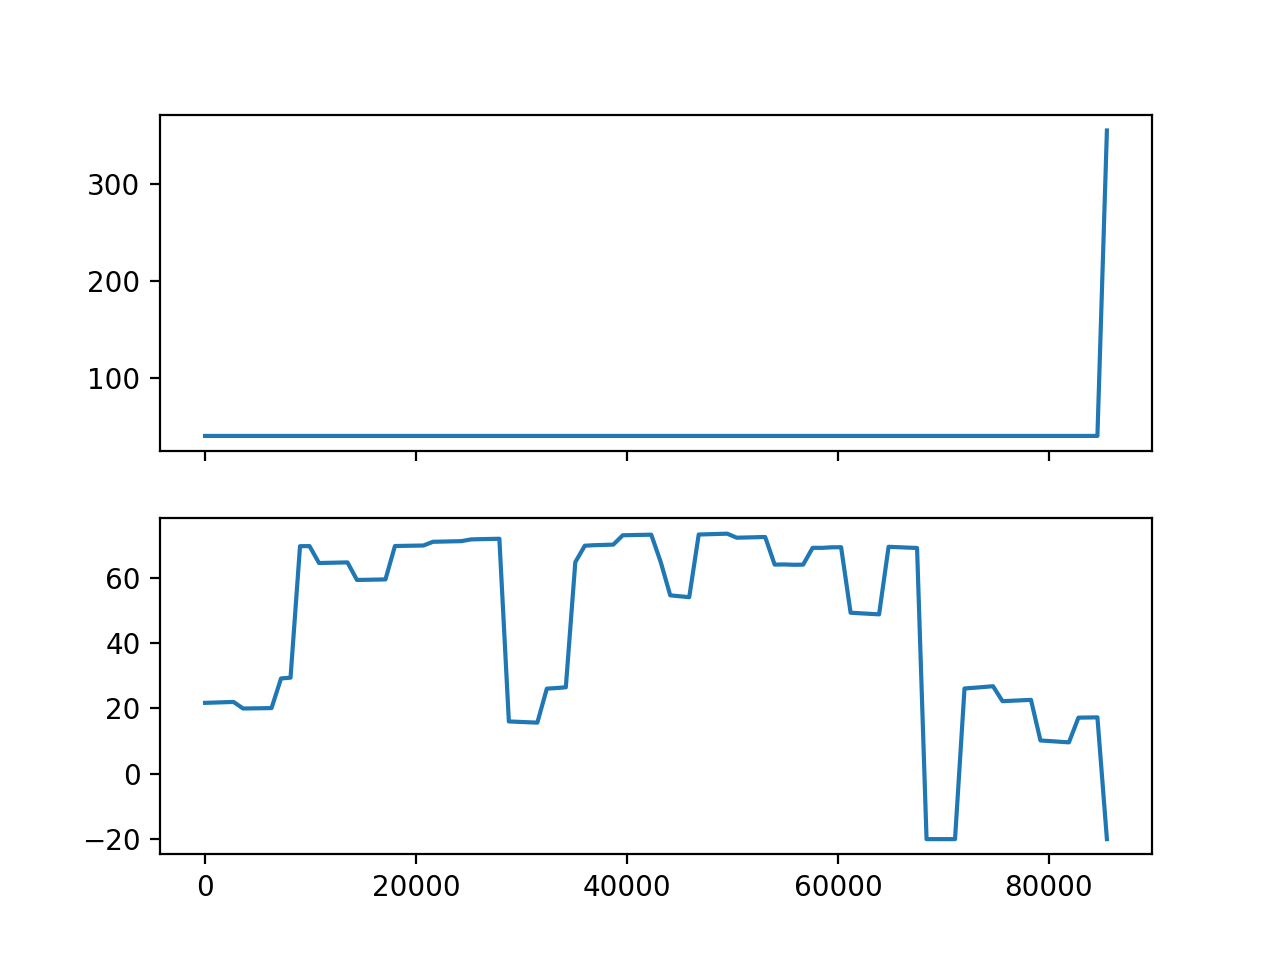

In [16]:
fig_5, ax_5 = plt.subplots(2,1, sharex=True)
ax_5[0].plot(results.link['setting']['V45'])
ax_5[1].plot(results.node['pressure']['J253']-results.node['pressure']['J130'])

# Energy of pumps

In [17]:
energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)
print(energy)


       P1  P10  P100  P1000  P101  P1016  P102  P1022  P1023  P1024  ...  \
0     NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
900   NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
1800  NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
2700  NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
3600  NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
...    ..  ...   ...    ...   ...    ...   ...    ...    ...    ...  ...   
81900 NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
82800 NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
83700 NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
84600 NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   
85500 NaN  NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN    NaN  ...   

       P999          PU10           PU2           PU5            PU6  \
0       NaN  21

<IPython.core.display.Javascript object>


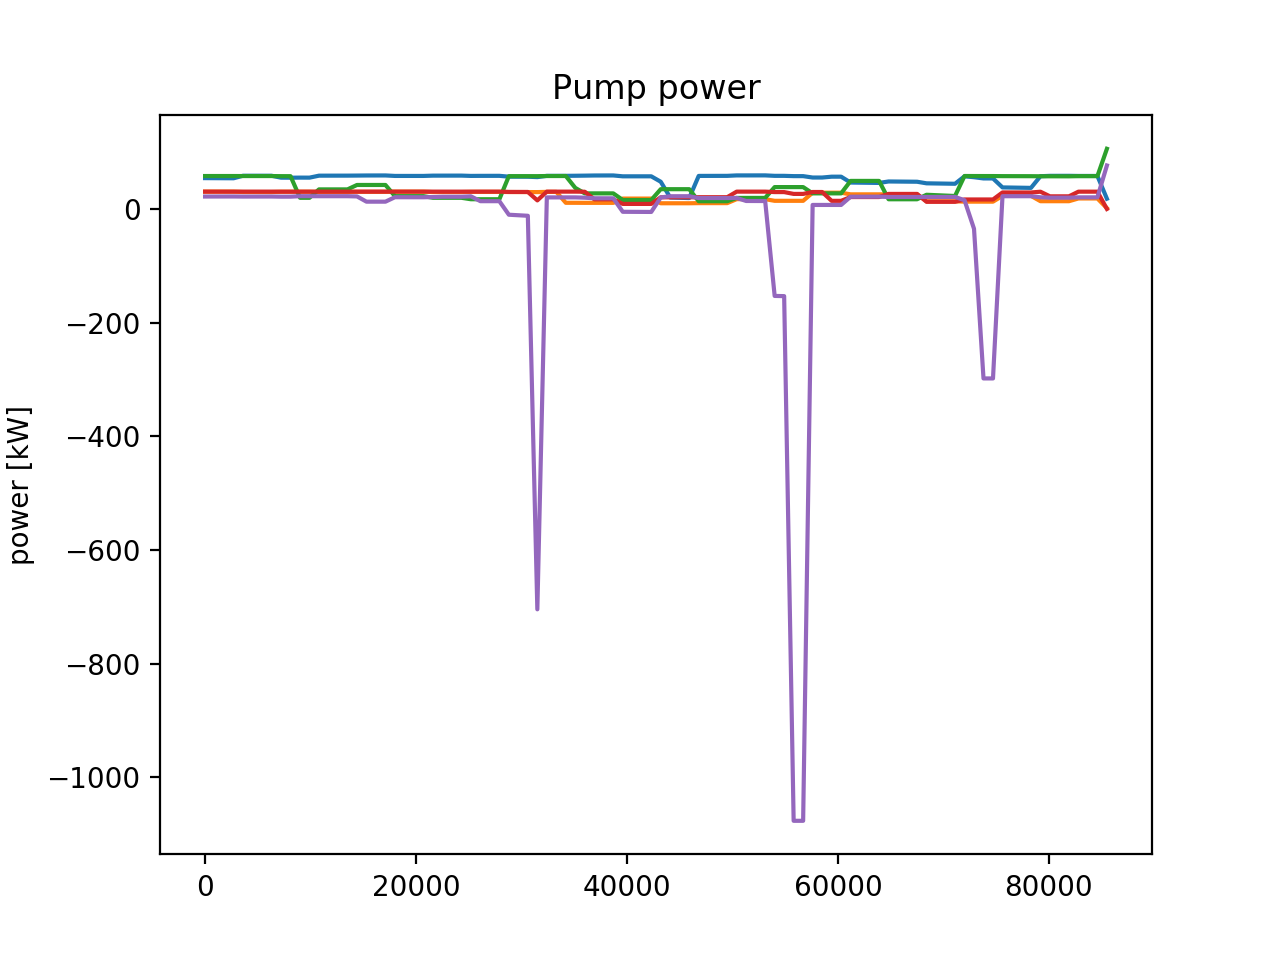

Text(0.5, 1.0, 'Pump power')

In [18]:
linkNames = ctown.getLinkName()
energyToPlot = energy[linkNames[0]] # Pumps
fig_6=plt.figure(0)
plt.plot(energyToPlot/1000)
plt.ylabel('power [kW]')
plt.title('Pump power')

# Controls

<IPython.core.display.Javascript object>


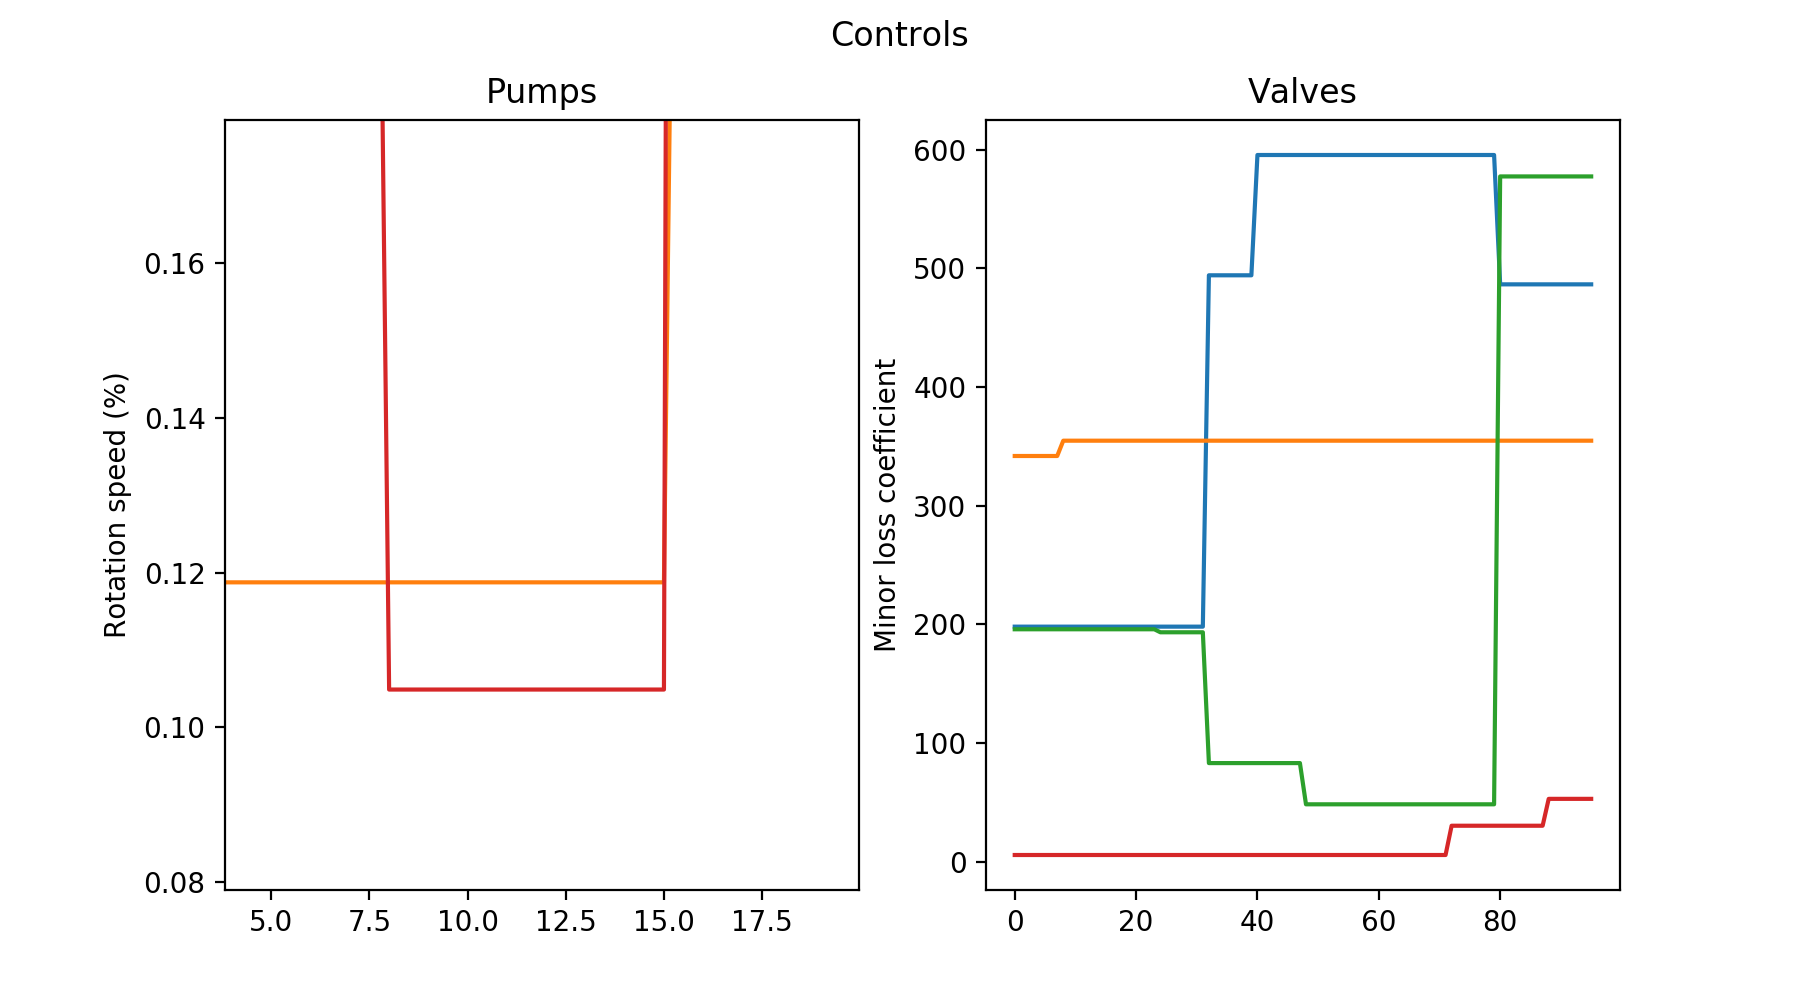

Text(0, 0.5, 'Minor loss coefficient')

In [19]:
fig_7, ax_7 = plt.subplots(1,2, figsize=(9,5))
fig_7.suptitle('Controls', fontsize=12)
ax_7[0].plot(results.setting[linkNames[0]])
ax_7[0].set_title('Pumps')
ax_7[0].set_ylabel('Rotation speed (%)')
ax_7[1].plot(results.setting[linkNames[2]])
ax_7[1].set_title('Valves')
ax_7[1].set_ylabel('Minor loss coefficient')

In [20]:
results.setting[:][0:18]

PU2       PU5       PU6       PU8      PU10      V1      V45  \
0   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
1   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
2   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
3   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
4   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
5   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
6   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
7   0.643952   0.11874   1.96858  0.546324  0.626413  198.11  341.853   
8   0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
9   0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
10  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
11  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
12  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
13  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
14  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
15  0.643952   0.11874  0.269152  0.104894   1.83181  198.11  354.744   
16  0.643952  0.528677    1.6223   1.69926   1.45517  198.11  354.744   
17  0.643952  0.528677    1.6223   1.69926   1.45517  198.11  354.744   

        V47       V2  
0   195.895  5.75724  
1   195.895  5.75724  
2   195.895  5.75724  
3   195.895  5.75724  
4   195.895  5.75724  
5   195.895  5.75724  
6   195.895  5.75724  
7   195.895  5.75724  
8   195.895  5.75724  
9   195.895  5.75724  
10  195.895  5.75724  
11  195.895  5.75724  
12  195.895  5.75724  
13  195.895  5.75724  
14  195.895  5.75724  
15  195.895  5.75724  
16  195.895  5.75724  
17  195.895  5.75724

<IPython.core.display.Javascript object>


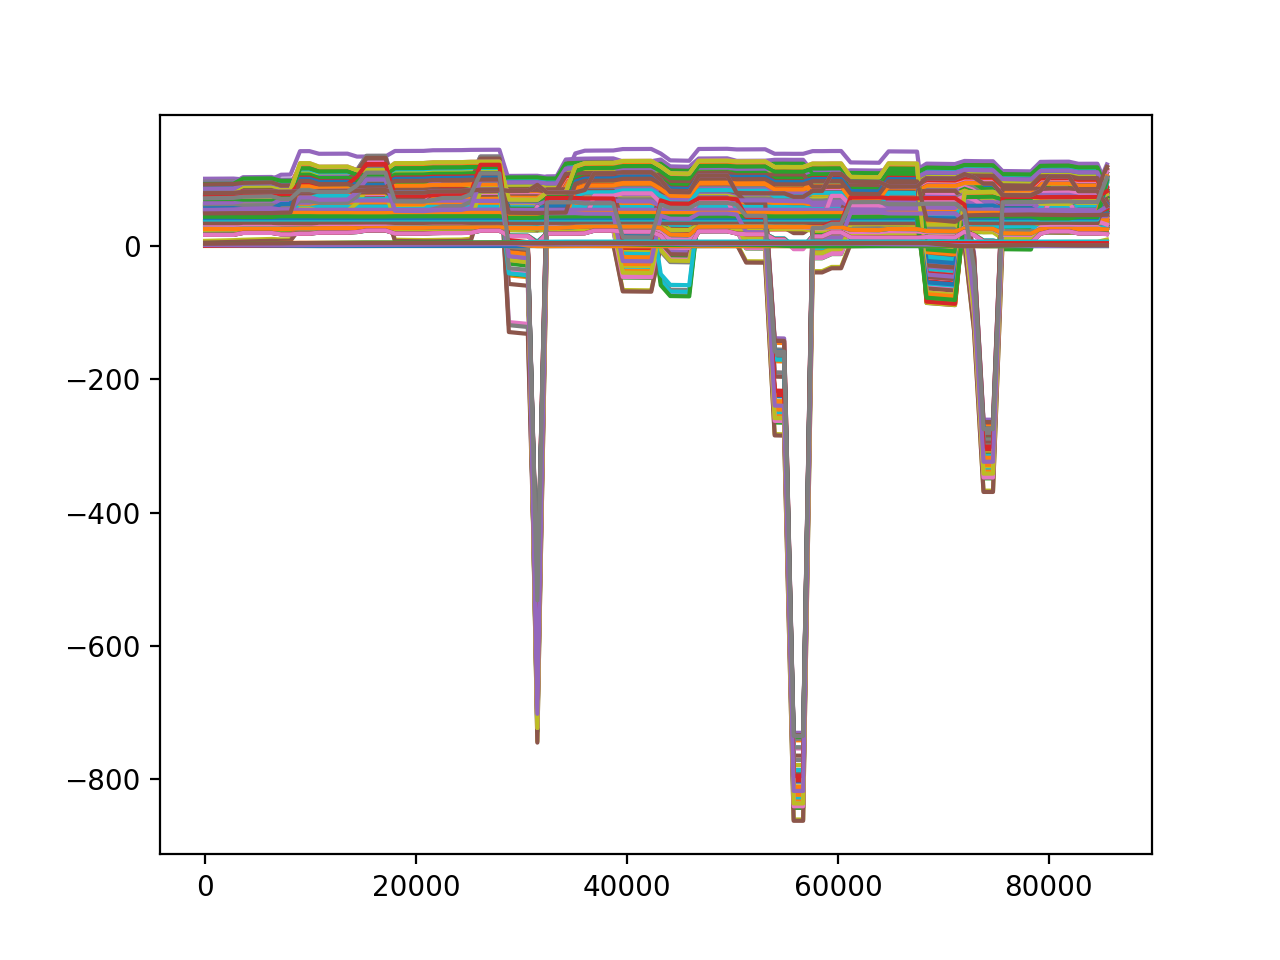

In [21]:
plt.figure()
plt.plot(results.node['pressure'])
plt.show()

<IPython.core.display.Javascript object>


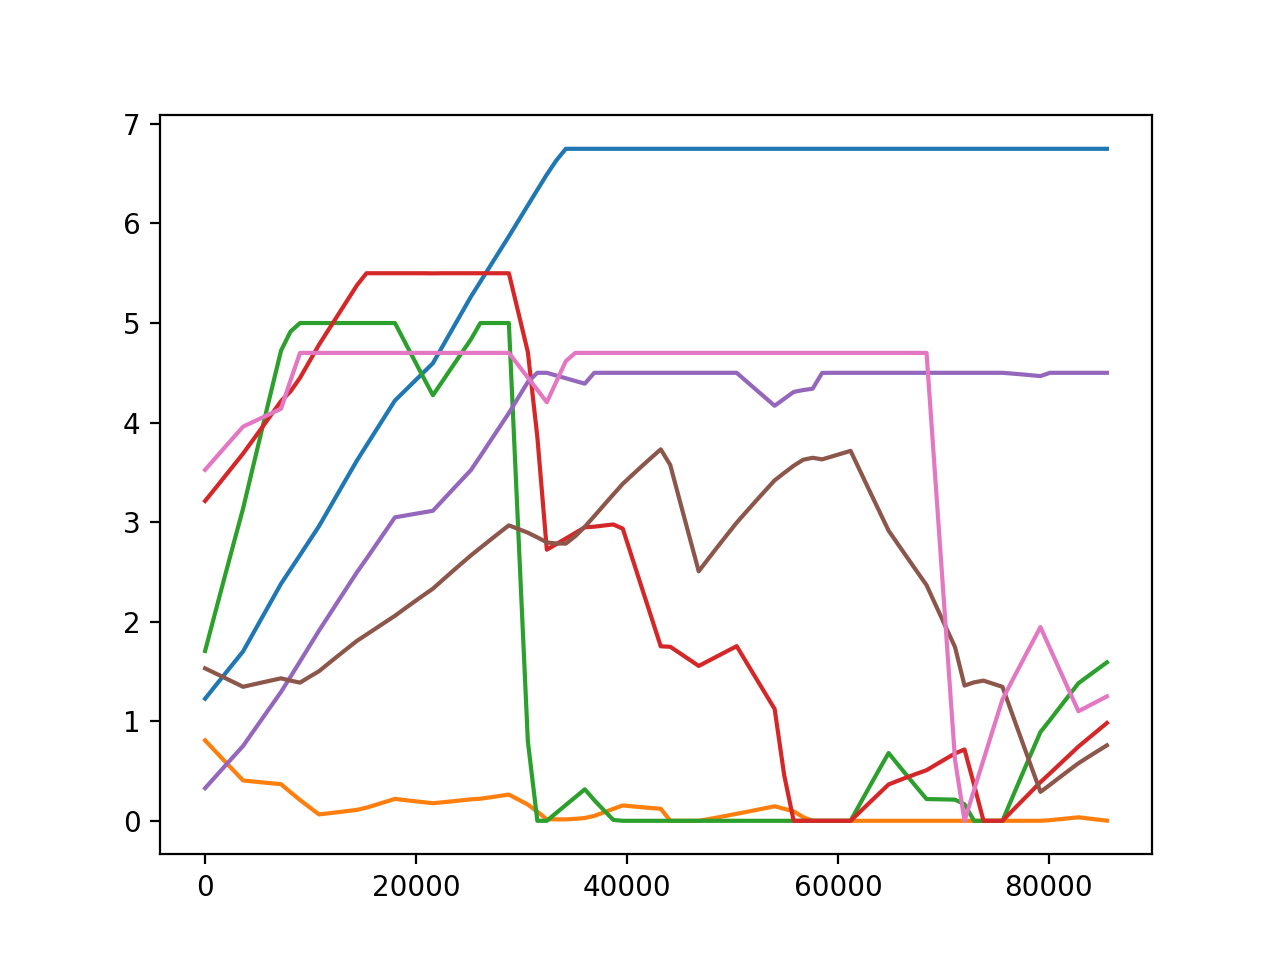

In [22]:
plt.figure()
plt.plot(results.tankElevations)
plt.show()